In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm


In [2]:
df = pd.read_csv("russian_passenger_air_service.csv")
df.head()


,Airport name,Year,January,February,March,April,May,June,July,August,September,October,November,December,Whole year,Airport coordinates
0,Abakan,2020,13495.0,14940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('91.399735'), Decimal('53.751351'))"
1,Aikhal,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('111.543324'), Decimal('65.957161'))"
2,Loss,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('125.398355'), Decimal('58.602489'))"
3,Amderma,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('61.577429'), Decimal('69.759076'))"
4,Anadyr (Carbon),2020,4255.0,4565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Decimal('177.738273'), Decimal('64.713433'))"


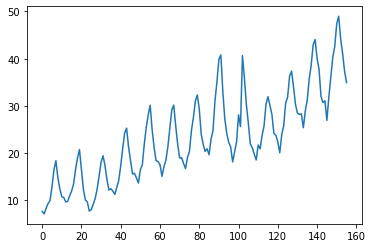

In [3]:
df = df.loc[(df["Airport name"] == "Krasnodar (Paszkowski)") & (df["Year"] < 2020)]
df["December"] = df["Whole year"] - df.iloc[:, 2:-3].sum(axis=1)
df.sort_values("Year", inplace=True)
data = df.values[:, 2:-2].flatten().astype(float) * 1e-4

plt.plot(data)


In [4]:
sm.tsa.adfuller(data)


(0.04639832803385646,
 0.962205082222035,
 13,
 142,
 {'1%': -3.477261624048995,
  '5%': -2.8821181874544233,
  '10%': -2.5777431104939494},
 565.736962988197)

In [5]:
first_diff = pd.Series(data).diff(1).dropna().values


In [6]:
sm.tsa.adfuller(first_diff)


(-2.726450060612842,
 0.06957201888430425,
 12,
 142,
 {'1%': -3.477261624048995,
  '5%': -2.8821181874544233,
  '10%': -2.5777431104939494},
 560.9317891215834)

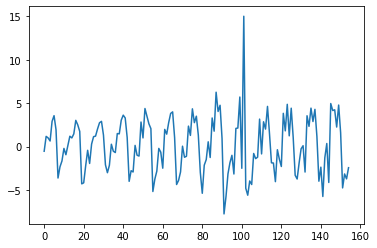

In [7]:
plt.plot(first_diff)


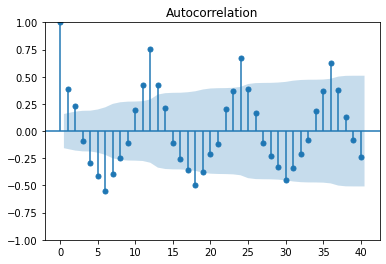

In [8]:
fig = sm.graphics.tsa.plot_acf(first_diff.squeeze(), lags=40)


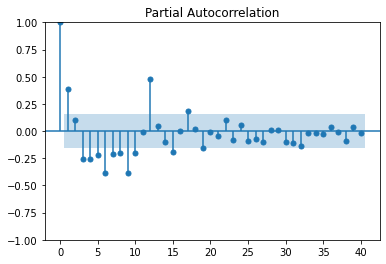

In [9]:
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, method='ywm')


In [ ]:
def sarimax_gridsearch(data, pdq, pdqs, maxiter=50):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    data, order=comb, seasonal_order=combs, trend=None
                )

                output = mod.fit(maxiter=maxiter)
                ans.append([comb, combs, output.bic])
            except:
                continue
    ans_df = pd.DataFrame(ans, columns=["pdq", "pdqs", "bic"])

    ans_df = ans_df.sort_values(by=["bic"], ascending=True)

    return ans_df


p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


sarimax_gridsearch(data[:132], pdq, pdqs)


| pdq       | pdqs          | bic        |
| --------- | ------------- | ---------- |
| (1, 2, 2) | (2, 0, 1, 12) | 34.072741  |
| (1, 1, 0) | (2, 1, 0, 12) | 470.516839 |
| (1, 1, 0) | (0, 1, 1, 12) | 471.142711 |
| (0, 1, 2) | (0, 1, 1, 12) | 473.271235 |
| (0, 1, 2) | (2, 1, 0, 12) | 473.791167 |

In [10]:
# 1 1 0. 2 1 0 12 -> 518.309 лучше чем якобы 34
sarimax = sm.tsa.statespace.SARIMAX(
    data[:144],
    order=[1, 1, 0],
    seasonal_order=[2, 1, 0, 12],
    trend=None,
).fit(maxiter=200)

print(sarimax.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -249.404
Date:                            Fri, 27 May 2022   AIC                            506.808
Time:                                    03:39:57   BIC                            518.309
Sample:                                         0   HQIC                           511.482
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4013      0.055     -7.291      0.000      -0.509      -0.293
ar.S.L12      -0.5049      0.055   

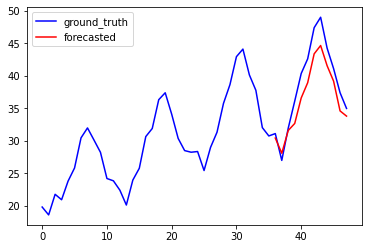

In [12]:
plt.plot(data[108:], color="blue", label="ground_truth")
plt.plot(
    np.arange(144 - 108, 156 - 108),
    sarimax.forecast(12),
    color="red",
    label="forecasted",
)
plt.legend(loc="best")
plt.show()
